# Regression Training

## Libraries

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [94]:
from nba_ou.data_preparation.missing_data.handle_missing_data import apply_missing_policy, compute_and_save_train_medians

## Load Data

In [95]:
data_path = "/home/adrian_alvarez/Projects/NBA_over_under_predictor/data/train_data/"
name = "training_data_from_2004-10-01_to_2026-01-10.csv"
path = data_path + name

df_stats = pd.read_csv(path)

dtype_dict = {col: str for col in df_stats.columns if "ID" in col.upper()}

df_stats = pd.read_csv(
    path,
    dtype=dtype_dict
)
df_stats['GAME_DATE'] = pd.to_datetime(df_stats['GAME_DATE']).dt.strftime('%Y-%m-%d')

/tmp/ipykernel_42083/3758133838.py:5: DtypeWarning: Columns (205,206,207,248,249,250,291,292,293,334,335,336,377,378,379,420,421,422,616,617,618,659,660,661,702,703,704,745,746,747,788,789,790,831,832,833) have mixed types. Specify dtype option on import or set low_memory=False.
  df_stats = pd.read_csv(path)
/tmp/ipykernel_42083/3758133838.py:9: DtypeWarning: Columns (205,206,207,248,249,250,291,292,293,334,335,336,377,378,379,420,421,422,616,617,618,659,660,661,702,703,704,745,746,747,788,789,790,831,832,833) have mixed types. Specify dtype option on import or set low_memory=False.
  df_stats = pd.read_csv(


In [96]:
df_stats= df_stats[df_stats['TOTAL_POINTS'] > 130]

In [97]:
#sort games by TOTAL_POINTS
# df_stats = df_stats.sort_values(by='TOTAL_POINTS', ascending=True).reset_index(drop=True)
df_stats[['TOTAL_POINTS', 'TOTAL_OVER_UNDER_LINE', 'TEAM_NAME_TEAM_HOME', 'TEAM_NAME_TEAM_AWAY', 'GAME_DATE']]

,TOTAL_POINTS,TOTAL_OVER_UNDER_LINE,TEAM_NAME_TEAM_HOME,TEAM_NAME_TEAM_AWAY,GAME_DATE
0,245,240.9999,Utah Jazz,Charlotte Hornets,2026-01-10
1,280,240.4999,Cleveland Cavaliers,Minnesota Timberwolves,2026-01-10
2,190,214.4999,Detroit Pistons,Los Angeles Clippers,2026-01-10
3,222,236.4999,Indiana Pacers,Miami Heat,2026-01-10
4,232,233.4999,Chicago Bulls,Dallas Mavericks,2026-01-10
...,...,...,...,...,...
23686,194,215.5000,New Orleans Pelicans,Sacramento Kings,2007-10-31
23687,166,191.0000,Cleveland Cavaliers,Dallas Mavericks,2007-10-31
23688,188,183.5000,Los Angeles Lakers,Houston Rockets,2007-10-30
23689,203,208.5000,San Antonio Spurs,Portland Trail Blazers,2007-10-30


In [98]:
df_stats.shape[0]


23690

In [99]:
df_stats

,TOTAL_OVER_UNDER_LINE,TEAM_ID_TEAM_HOME,TEAM_CITY_TEAM_HOME,TEAM_ABBREVIATION_TEAM_HOME,TEAM_NAME_TEAM_HOME,MATCHUP_TEAM_HOME,GAME_NUMBER_TEAM_HOME,TEAM_ID_TEAM_AWAY,TEAM_CITY_TEAM_AWAY,TEAM_ABBREVIATION_TEAM_AWAY,...,PTS_TREND_SLOPE_DIFF_HOME_MINUS_AWAY,PTS_TREND_SLOPE_SUM_HOME_PLUS_AWAY,TRAVEL_RECENCY_RATIO_HOME_2D_OVER_14D,TRAVEL_RECENCY_RATIO_AWAY_2D_OVER_14D,REST_DAYS_DIFF_HOME_MINUS_AWAY,INJURY_PTS_SHARE_HOME,INJURY_PTS_SHARE_AWAY,STAR_PTS_PCT_DIFF_HOME_MINUS_AWAY,POSS_X_TSPCT_HOME,POSS_X_TSPCT_AWAY
0,240.9999,1610612762,Utah,UTA,Utah Jazz,UTA vs. CHA,38,1610612766,Charlotte,CHA,...,1.7,-3.1,0.788795,0.000000,0,0.240990,0.133469,0.022339,60.680317,57.657276
1,240.4999,1610612739,Cleveland,CLE,Cleveland Cavaliers,CLE vs. MIN,40,1610612750,Minnesota,MIN,...,-3.8,-13.4,0.773813,0.000000,0,0.098350,0.082884,0.006726,59.123238,54.357701
2,214.4999,1610612765,Detroit,DET,Detroit Pistons,DET vs. LAC,38,1610612746,LA,LAC,...,-8.5,-3.3,0.000000,0.234741,2,0.495857,0.234389,-0.156275,58.487861,56.322250
3,236.4999,1610612754,Indiana,IND,Indiana Pacers,IND vs. MIA,39,1610612748,Miami,MIA,...,8.6,-1.6,0.727915,0.000000,-2,0.379738,0.021147,0.006671,56.971687,59.561623
4,233.4999,1610612741,Chicago,CHI,Chicago Bulls,CHI vs. DAL,38,1610612742,Dallas,DAL,...,2.3,0.1,0.000000,0.766714,1,0.289831,0.425103,-0.010188,58.130139,57.252427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,215.5000,1610612740,New Orleans,NOH,New Orleans Pelicans,NOH vs. SAC,1,1610612758,Sacramento,SAC,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
23687,191.0000,1610612739,Cleveland,CLE,Cleveland Cavaliers,CLE vs. DAL,1,1610612742,Dallas,DAL,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
23688,183.5000,1610612747,Los Angeles,LAL,Los Angeles Lakers,LAL vs. HOU,1,1610612745,Houston,HOU,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
23689,208.5000,1610612759,San Antonio,SAS,San Antonio Spurs,SAS vs. POR,1,1610612757,Portland,POR,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [100]:
#count nas in TOTA_OVER_UNDER_LINE
nans = df_stats['TOTAL_OVER_UNDER_LINE'].isna().sum()
print(f"Number of NaNs in TOTAL_OVER_UNDER_LINE: {nans}")

Number of NaNs in TOTAL_OVER_UNDER_LINE: 1702


In [101]:
df_stats.dropna(subset=['TOTAL_OVER_UNDER_LINE'], inplace=True)
df_stats = df_stats[df_stats['TOTAL_OVER_UNDER_LINE'] > 100]

In [102]:
df_stats['SEASON_YEAR'].unique()

array([2025, 2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015,
       2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007])

In [103]:
#drop season 2007
df_stats = df_stats[df_stats['SEASON_YEAR'] != 2007]

In [104]:
df_to_train = df_stats.copy()

In [105]:
text_columns = df_to_train.select_dtypes(include=['object', 'string']).columns

# Print the names of the columns containing text
# print("Text columns:", list(text_columns))
cols_to_drop = ['SEASON_ID', 'GAME_ID', 'SEASON_TYPE',  'TEAM_ID_TEAM_HOME',
       'TEAM_ID_TEAM_AWAY','IS_OVERTIME']

cols_to_drop += [
    "MATCHUP_TEAM_HOME",
    "GAME_NUMBER_TEAM_HOME",
    "TEAM_CITY_TEAM_AWAY",
    "TEAM_ABBREVIATION_TEAM_AWAY",
    "TEAM_ABBREVIATION_TEAM_HOME",
    "TEAM_CITY_TEAM_HOME",
    "TEAM_NAME_TEAM_AWAY",
    "MATCHUP_TEAM_AWAY",
    'TEAM_NAME_TEAM_HOME'
]
cols_to_drop += list(text_columns)

cols_to_drop.pop(cols_to_drop.index('GAME_DATE'))

df_to_train.drop(columns=cols_to_drop, inplace=True, errors='ignore')


In [106]:
#Calculate number fo rows with at least 1 NA in total and in percentage
rows_with_na = df_to_train.isna().any(axis=1).sum()
total_rows = df_to_train.shape[0]
percentage_with_na = (rows_with_na / total_rows) * 100
print(f"Rows with at least one NA: {rows_with_na} out of {total_rows} ({percentage_with_na:.2f}%)")

Rows with at least one NA: 1862 out of 20774 (8.96%)


In [107]:
# Count NAs per column
na_counts = df_to_train.isna().sum()

# Get most common SEASON_YEAR for nulls in each column
most_common_season = []
for col in df_to_train.columns:
    if na_counts[col] > 0:
        # Get rows where this column is null
        null_rows = df_stats[df_stats[col].isna()]
        if len(null_rows) > 0 and 'SEASON_YEAR' in df_stats.columns:
            # Find most common SEASON_YEAR for these null rows
            common_season = null_rows['SEASON_YEAR'].mode()
            most_common_season.append(common_season.iloc[0] if len(common_season) > 0 else None)
        else:
            most_common_season.append(None)
    else:
        most_common_season.append(None)

na_counts_df = pd.DataFrame({
    'Column': na_counts.index,
    'NA_Count': na_counts.values,
    'NA_Percentage': (na_counts.values / len(df_to_train) * 100).round(2),
    'Most_Common_Season_Year': most_common_season
}).sort_values('NA_Count', ascending=False)

# Show only columns with NAs
na_counts_df[na_counts_df['NA_Count'] > 0]

,Column,NA_Count,NA_Percentage,Most_Common_Season_Year
514,TOTAL_OVER_UNDER_LINE_COMBINED_TREND_SLOPE_LAS...,627,3.02,2022.0
609,TRAVEL_RECENCY_RATIO_AWAY_2D_OVER_14D,561,2.70,2019.0
605,PTS_FORM_Z_AWAY_LAST5_VS_SEASON,561,2.70,2010.0
604,PTS_FORM_Z_HOME_LAST5_VS_SEASON,554,2.67,2022.0
494,AVG_POINTS_CONCEDED_AWAY_BEFORE_GAME,540,2.60,2008.0
...,...,...,...,...
528,REF_TRIO_DIFFERENCE_FROM_LINE_DIFF_BEFORE,23,0.11,2023.0
531,MONEYLINE_TEAM_HOME,12,0.06,2011.0
530,SPREAD,12,0.06,2011.0
597,IMPLIED_PTS_HOME,12,0.06,2011.0


In [108]:
# df_to_train.fillna(0, inplace=True)

In [109]:
df_to_train['TOTAL_OVER_UNDER_LINE'].unique()

array([240.9999, 240.4999, 214.4999, 236.4999, 233.4999, 230.4999,
       231.4999, 228.9999, 221.9999, 228.4999, 229.4999, 243.4999,
       226.9999, 223.9999, 232.4999, 238.9999, 227.4999, 232.9999,
       246.4999, 222.9999, 242.9999, 222.4999, 220.9999, 234.4999,
       237.4999, 234.9999, 237.9999, 244.4999, 236.9999, 241.9999,
       239.4999, 238.4999, 224.4999, 247.9999, 239.9999, 248.4999,
       219.9999, 235.4999, 226.4999, 216.9999, 229.9999, 249.4999,
       235.9999, 218.4999, 246.9999, 241.4999, 233.9999, 243.9999,
       231.9999, 250.4999, 225.9999, 245.4999, 254.4999, 220.4999,
       225.4999, 251.4999, 215.9999, 221.4999, 242.4999, 215.4999,
       224.9999, 223.4999, 219.4999, 244.9999, 227.9999, 248.9999,
       249.9999, 218.9999, 230.9999, 216.4999, 217.4999, 213.9999,
       210.9999, 207.9999, 203.4999, 209.4999, 201.4999, 208.9999,
       209.9999, 212.9999, 205.9999, 206.4999, 202.4999, 210.4999,
       199.4999, 211.4999, 198.9999, 211.9999, 205.4999, 200.4

In [110]:
print("Applying missing data policy...")
print(f"Data shape before handling missing data: {df_to_train.shape}")

Applying missing data policy...
Data shape before handling missing data: (20774, 616)


In [111]:
    # Training time
train_medians = compute_and_save_train_medians(df_to_train)

# Prediction time
df_to_train, report = apply_missing_policy(
    df_to_train,
    train_medians=train_medians,
    current_total_line_col="TOTAL_OVER_UNDER_LINE",
    drop_mode="strict",)

In [112]:
# report

In [113]:
print(f"Data shape after handling missing data: {df_to_train.shape}")

Data shape after handling missing data: (20378, 616)


In [114]:
null_rows = df_to_train[df_to_train.isnull().any(axis=1)]
print(f"Total number of null values in the DataFrame: {null_rows.shape[0]}")
print(f"Percentage of null values in the DataFrame: {null_rows.shape[0] / df_to_train.shape[0] * 100:.2f}%")
print(f"Total number of rows in the DataFrame: {df_to_train.shape[0]}")

null_columns = df_to_train.columns[df_to_train.isnull().any()].tolist()
print(f"Columns with null values: {null_columns}")


Total number of null values in the DataFrame: 0
Percentage of null values in the DataFrame: 0.00%
Total number of rows in the DataFrame: 20378
Columns with null values: []


In [122]:
df_to_train.drop(columns='GAME_DATE', inplace=True)

KeyError: "['GAME_DATE'] not found in axis"

In [123]:
df_to_train['DIST_TO_TOTAL'] = df_to_train['TOTAL_OVER_UNDER_LINE'] - df_to_train['TOTAL_POINTS']

In [124]:
#print this row
df_to_train.loc[df_to_train['DIST_TO_TOTAL'].idxmax()][['TOTAL_OVER_UNDER_LINE', 'TOTAL_POINTS', 'DIST_TO_TOTAL']]

TOTAL_OVER_UNDER_LINE    227.5
TOTAL_POINTS               147
DIST_TO_TOTAL             80.5
Name: 21010, dtype: object

In [126]:
df_to_train.loc[df_to_train['DIST_TO_TOTAL'].idxmin()][['TOTAL_OVER_UNDER_LINE', 'TOTAL_POINTS', 'DIST_TO_TOTAL']]

TOTAL_OVER_UNDER_LINE    215.0
TOTAL_POINTS               317
DIST_TO_TOTAL           -102.0
Name: 8106, dtype: object

In [ ]:
print(df_to_train['DIST_TO_TOTAL'])

0        -4.0001
1       -39.5001
2        24.4999
3        14.4999
4         1.4999
          ...   
22353    19.0000
22354    39.5000
22355    -3.5000
22356     7.0000
22358   -13.5000
Name: DIST_TO_LINE, Length: 20378, dtype: float64


## Train / Test

In [81]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df_to_train.drop(cols_to_drop +['DIST_TO_LINE'] + ['TOTAL_POINTS'], axis=1, errors='ignore')
y = df_to_train['DIST_TO_LINE']

In [83]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=16)

In [33]:
df_to_train['IS_TRAINING_DATA'] = False

# Mark True for the rows in the training set
df_to_train.loc[X_train.index, 'IS_TRAINING_DATA'] = True
output_name = f"{data_path}/training_data_with_missing_data_handled_from_2004-10-01_to_2026-01-10.csv"
df_to_train.to_csv(output_name, index=False)

In [84]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
# Check number of coulmns
print(f"Number of columns in training set: {X_train.shape[1]}")
print(f"Number of columns in test set: {X_test.shape[1]}")

Training set size: 17322
Test set size: 3057
Number of columns in training set: 614
Number of columns in test set: 614


## Cross-validation

In [85]:
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, root_mean_squared_error

In [86]:
# Declare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=16)

In [87]:
# Declare scores to be used
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(root_mean_squared_error),
    'MAE': make_scorer(mean_absolute_error),
}

In [88]:
def print_metrics(cv_results):
    for sc in scoring.keys():
        print(f'Train {sc}:', cv_results[f'train_{sc}'].mean().round(5))
        print(f'Validation {sc}:', cv_results[f'test_{sc}'].mean().round(5))
        print()
    

In [89]:
def real_vs_pred(model, X_train, y_train):
    preds = cross_val_predict(model, X_train, y_train, cv=kf, n_jobs=-1)
    x_line = np.arange(y_train.min(), y_train.max())
    plt.scatter(y_train, preds)
    plt.plot(x_line, x_line, color='orange')
    plt.xlabel('Real target')
    plt.ylabel('Predicted target')
    plt.show()

## Baseline

In [90]:
from sklearn.dummy import DummyRegressor

In [91]:
season_bl = DummyRegressor(strategy='mean')
cv_results = cross_validate(season_bl, X_train, y_train, cv=kf,
                            scoring=scoring, return_train_score=True)
season_bl.fit(X_train, y_train)
print_metrics(cv_results)

Train MSE: 519.92087
Validation MSE: 520.00044

Train RMSE: 22.8016
Validation RMSE: 22.80078

Train MAE: 18.41047
Validation MAE: 18.41106



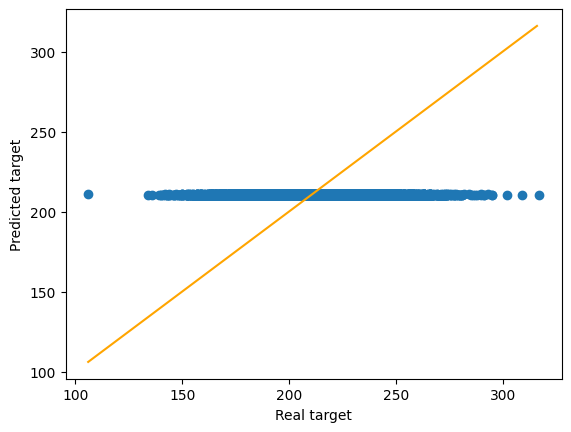

In [92]:
real_vs_pred(season_bl, X_train, y_train)

In [93]:
y_pred_baseline_2 = X_train['PTS_SEASON_BEFORE_AVG_TEAM_HOME'] + X_train['PTS_SEASON_BEFORE_AVG_TEAM_AWAY']

# Evaluate manually
mse = mean_squared_error(y_train, y_pred_baseline_2)
mae = mean_absolute_error(y_train, y_pred_baseline_2)
rmse = root_mean_squared_error(y_train, y_pred_baseline_2)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 347.61
RMSE: 18.64
MAE: 14.82


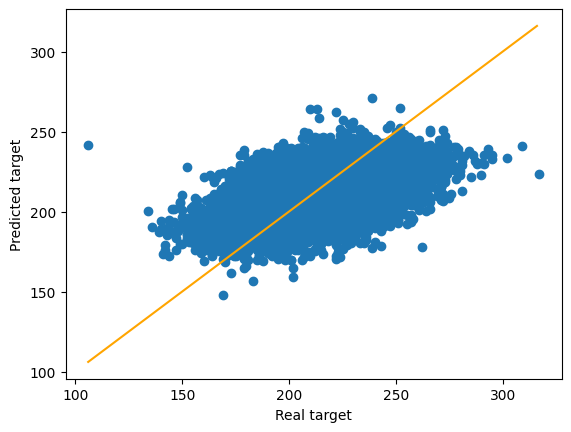

In [94]:
x_line = np.arange(y_train.min(), y_train.max())
plt.scatter(y_train, y_pred_baseline_2)
plt.plot(x_line, x_line, color='orange')
plt.xlabel('Real target')
plt.ylabel('Predicted target')
plt.show()

In [95]:
# Baseline 3: Predict the betting line (TOTAL_OVER_UNDER_LINE)
y_pred_baseline_3 = X_train['TOTAL_OVER_UNDER_LINE']

# Evaluate
mse = mean_squared_error(y_train, y_pred_baseline_3)
mae = mean_absolute_error(y_train, y_pred_baseline_3)
rmse = root_mean_squared_error(y_train, y_pred_baseline_3)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 401.50
RMSE: 20.04
MAE: 15.92


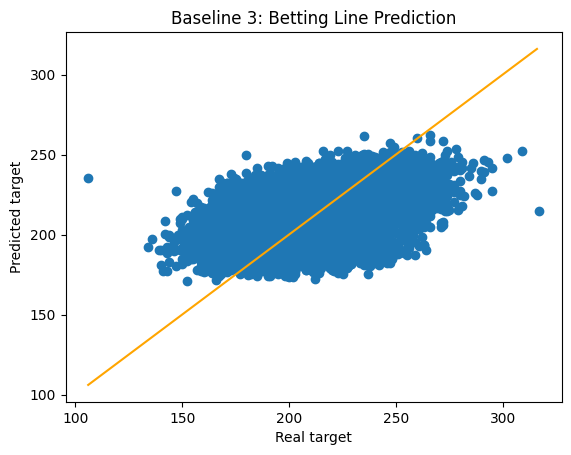

In [96]:
x_line = np.arange(y_train.min(), y_train.max())
plt.scatter(y_train, y_pred_baseline_3)
plt.plot(x_line, x_line, color='orange')
plt.xlabel('Real target')
plt.ylabel('Predicted target')
plt.title('Baseline 3: Betting Line Prediction')
plt.show()

## Linear Regression

In [97]:
from sklearn.linear_model import LinearRegression

In [39]:
lr = LinearRegression()
cv_results = cross_validate(lr, X_train, y_train, cv=kf,
                            scoring=scoring, return_train_score=True)

lr.fit(X_train, y_train)
print_metrics(cv_results)

Train MSE: 277.12791
Validation MSE: 305.06808

Train RMSE: 16.6471
Validation RMSE: 17.46418

Train MAE: 13.2452
Validation MAE: 13.84148



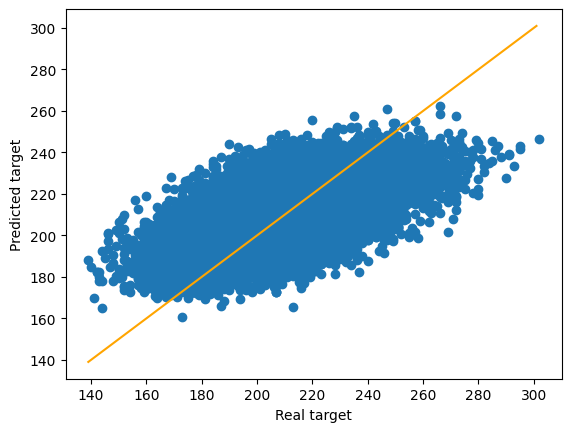

In [126]:
real_vs_pred(lr, X_train, y_train)

## Random Forest

In [75]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
X_train.shape

(17322, 614)

In [77]:
rf = RandomForestRegressor(100, max_depth=5, max_features=0.6, n_jobs=-1, random_state=16)
cv_results = cross_validate(rf, X_train, y_train, cv=kf,
                            scoring=scoring, return_train_score=True, n_jobs=-1)

rf.fit(X_train, y_train)
print_metrics(cv_results)

Train MSE: 286.30213
Validation MSE: 304.70507

Train RMSE: 16.9204
Validation RMSE: 17.45493

Train MAE: 13.49597
Validation MAE: 13.90037



In [48]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate

# Example XGBoost regressor:
xgb_reg = XGBRegressor(
    max_depth=5,
    learning_rate=0.025,
    n_estimators=250,
    subsample=1.0,       # Equivalent to max_samples in GBRegressor
    colsample_bytree=0.8, # Equivalent to max_features in GBRegressor
    n_jobs=-2,
    objective="reg:absoluteerror"
)

cv_results = cross_validate(
    xgb_reg, 
    X_train, y_train, 
    cv=kf, 
    scoring=scoring,      # Use your custom scoring or e.g. 'neg_mean_absolute_error'
    return_train_score=True,
    n_jobs=-2
)
# Train final model on full train set
xgb_reg.fit(X_train, y_train)

# Print metrics
print_metrics(cv_results)

Train MSE: 240.96984
Validation MSE: 298.9438

Train RMSE: 15.52318
Validation RMSE: 17.28908

Train MAE: 11.74963
Validation MAE: 13.7735



## Hyperparameter Tuning

In [98]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate

### Randomized Search

### Grid Search

In [99]:
def print_rs_reg_scores(rs_model, best_idx):
    print(rs_model.best_params_)
    print()
    print('Train MAE:', rs_model.cv_results_['mean_train_MAE'][best_idx].round(5))
    print('Validation MAE:', rs_model.cv_results_['mean_test_MAE'][best_idx].round(5))
    # print()
    print('Train MSE:', rs_model.cv_results_['mean_train_MSE'][best_idx].round(5))
    print('Validation MSE:', rs_model.cv_results_['mean_test_MSE'][best_idx].round(5))
    # print('Train MedAE:', rs_model.cv_results_['mean_train_MedAE'][best_idx].round(1))
    # print('Validation MedAE:', rs_model.cv_results_['mean_test_MedAE'][best_idx].round(1))

In [81]:
import os
n_jobs = max(1, os.cpu_count() - 2)
print(f"Number of jobs: {n_jobs}")

Number of jobs: 10


In [82]:
X_train.shape


(17322, 614)

In [49]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the base model
xgb_reg = XGBRegressor(random_state=16, n_jobs=-1, tree_method="hist"
)

# Define hyperparameter grid
params = [{
    'n_estimators': [200,100, 500],  # Similar to GBRT
    'learning_rate': [0.02, 0.04],  # Fine-tuning LR
    # 'max_depth': [4, 5],  # Keeping it limited for efficiency
    # 'min_child_weight': [3, 4],  # Similar to min_samples_split in GBRT
    # 'subsample': [0.8, 0.5],  # Control for overfitting
    # 'colsample_bytree': [0.8, 1.0],  # Similar to max_features in GBRT
    'gamma': [0],  # Regularization parameter
}]

# GridSearchCV setup
xgb_gs = GridSearchCV(
    xgb_reg,
    param_grid=params,
    scoring=scoring,
    cv=kf,
    verbose=3,
    refit=lambda x: x["mean_test_MAE"].argmin(),  # Select best model based on MAE
    return_train_score=True,
    n_jobs=-1,

)

# Fit model
xgb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 5/5] END gamma=0, learning_rate=0.02, n_estimators=100; MAE: (train=12.481, test=14.209) MSE: (train=264.512, test=310.326) RMSE: (train=16.264, test=17.616) total time= 1.2min
[CV 3/5] END gamma=0, learning_rate=0.02, n_estimators=100; MAE: (train=12.478, test=14.146) MSE: (train=262.017, test=317.945) RMSE: (train=16.187, test=17.831) total time= 1.3min
[CV 2/5] END gamma=0, learning_rate=0.02, n_estimators=100; MAE: (train=12.559, test=13.692) MSE: (train=265.664, test=297.452) RMSE: (train=16.299, test=17.247) total time= 1.3min
[CV 4/5] END gamma=0, learning_rate=0.02, n_estimators=100; MAE: (train=12.449, test=14.108) MSE: (train=261.410, test=316.541) RMSE: (train=16.168, test=17.792) total time= 1.3min
[CV 1/5] END gamma=0, learning_rate=0.02, n_estimators=100; MAE: (train=12.527, test=13.873) MSE: (train=264.967, test=302.445) RMSE: (train=16.278, test=17.391) total time= 1.4min
[CV 5/5] END gamma=0, learning_rate

GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
             param_grid=[{'gamma': [0], 'learning_rate': [0.02, 0.04],
                          'n_estimators': [200, 100, 500]}],
             refit=<function <lambda> at 0x723492103d80>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=3)

In [52]:
# Print metrics
xgb_gs.best_params_
print_rs_reg_scores(xgb_gs, xgb_gs.best_index_)

{'gamma': 0, 'learning_rate': 0.02, 'n_estimators': 500}

Train MAE: 10.01451
Validation MAE: 13.76801
Train MSE: 195.7818
Validation MSE: 299.0757


In [53]:
xgb_reg = XGBRegressor(
    random_state=16,
    n_jobs=-1,

)

# Pair LR and n_estimators to avoid wasting compute on mismatched combos
param_grid = [
    # Regime A: what your current data seems to like (0.02, ~200) plus nearby
    {
        "learning_rate": [0.02],
        "n_estimators": [200, 300, 400],
        "max_depth": [3, 4, 5],
        "min_child_weight": [3, 5, 8],
        "subsample": [0.5, 0.7],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "gamma": [0],
        "reg_lambda": [1, 2],
        "reg_alpha": [0, 0.1],
    },
    # Regime B: lower LR + more trees (close to your older best)
    {
        "learning_rate": [0.01, 0.015],
        "n_estimators": [300, 450, 600],
        "max_depth": [3, 4],
        "min_child_weight": [4, 6, 8],
        "subsample": [0.3, 0.6],
        "colsample_bytree": [0.6, 0.8],
        "gamma": [0],
        "reg_lambda": [1, 2],
        "reg_alpha": [0, 0.1],
    },
]

xgb_gs = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring=scoring,
    cv=kf,
    verbose=2,
    refit=lambda x: x["mean_test_MAE"].argmin(),  # as you are doing
    return_train_score=True,
    n_jobs=-1,
)

xgb_gs.fit(X_train, y_train)


Fitting 5 folds for each of 1224 candidates, totalling 6120 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=  41.7s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.5; total time=  42.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.5; total time=  42.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.5; total time=  43.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=1, subsample=0.5; total time=  44.6s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=3, mi

GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                          'n_estimators': [300, 450, 600],
                          'reg_alpha': [0, 0.1], 'reg_lambda': [1, 2],
                          'subsample': [0.3, 0.6]}],
             refit=<function <lambda> at 0x72349200ac00>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=2)

In [54]:
# Print metrics
xgb_gs.best_params_
print_rs_reg_scores(xgb_gs, xgb_gs.best_index_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.015, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 600, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.3}

Train MAE: 12.28
Validation MAE: 13.6394
Train MSE: 237.59445
Validation MSE: 294.46496


In [100]:
xgb_reg = XGBRegressor(
    random_state=16,
    n_jobs=-2,

)

# Pair LR and n_estimators to avoid wasting compute on mismatched combos
param_grid = [
    # Regime A: what your current data seems to like (0.02, ~200) plus nearby
    {
        "learning_rate": [0.02, 0.025, 0.017,0.1],
        "n_estimators": [500,400],
        "max_depth": [4],
        "min_child_weight": [4],
        "subsample": [0.3, 0.4],
        "colsample_bytree": [0.8],
        "gamma": [0],
        "reg_lambda": [2],
        "reg_alpha": [0, 0.01],
    }
]

xgb_gs = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring=scoring,
    cv=kf,
    verbose=3,
    refit=lambda x: x["mean_test_MAE"].argmin(),  # as you are doing
    return_train_score=True,
    n_jobs=-2,
)

xgb_gs.fit(X_train, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 5/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=4, min_child_weight=4, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.4; MAE: (train=12.126, test=13.753) MSE: (train=232.159, test=293.331) RMSE: (train=15.237, test=17.127) total time= 1.8min
[CV 5/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=4, min_child_weight=4, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.3; MAE: (train=12.128, test=13.740) MSE: (train=232.823, test=293.625) RMSE: (train=15.259, test=17.136) total time= 1.9min
[CV 1/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=4, min_child_weight=4, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.3; MAE: (train=12.177, test=13.565) MSE: (train=233.918, test=290.167) RMSE: (train=15.294, test=17.034) total time= 1.9min
[CV 4/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=4, min_child_weight=4, n_estim

/home/adrian_alvarez/Projects/NBA_over_under_predictor/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=4, min_child_weight=4, n_estimators=500, reg_alpha=0.01, reg_lambda=2, subsample=0.4; MAE: (train=12.137, test=13.509) MSE: (train=232.131, test=288.414) RMSE: (train=15.236, test=16.983) total time= 2.1min
[CV 2/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=4, min_child_weight=4, n_estimators=500, reg_alpha=0.01, reg_lambda=2, subsample=0.4; MAE: (train=12.168, test=13.417) MSE: (train=232.587, test=290.078) RMSE: (train=15.251, test=17.032) total time= 2.0min
[CV 3/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=4, min_child_weight=4, n_estimators=500, reg_alpha=0.01, reg_lambda=2, subsample=0.4; MAE: (train=12.070, test=13.805) MSE: (train=230.162, test=301.646) RMSE: (train=15.171, test=17.368) total time= 2.0min
[CV 5/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.02, max_depth=4, min_child_weight=4, n_estimators=500, reg_alpha=0.01, reg_lambda=2, subsample=0.

GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                          'n_estimators': [500, 400], 'reg_alpha': [0, 0.01],
                          'reg_lambda': [2], 'subsample': [0.3, 0.4]}],
             refit=<function <lambda> at 0x72351c07a480>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=3)

In [101]:
# Print metrics
xgb_gs.best_params_
print_rs_reg_scores(xgb_gs, xgb_gs.best_index_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.4}

Train MAE: 11.81133
Validation MAE: 13.64301
Train MSE: 219.6666
Validation MSE: 294.55679


In [108]:
# {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.4}

xgb_reg = XGBRegressor(
    random_state=16,
    n_jobs=-2,

)

param_grid = [
    {
        "learning_rate": [0.025, ],
        "n_estimators": [500,450,550],
        "max_depth": [4],
        "min_child_weight": [4],
        "subsample": [0.4],
        "colsample_bytree": [0.8],
        "gamma": [0],
        "reg_lambda": [2],
        "reg_alpha": [0],
    }
]

xgb_gs = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring=scoring,
    cv=kf,
    verbose=1,
    refit=lambda x: x["mean_test_MAE"].argmin(),  
    return_train_score=True,
    n_jobs=-2,
)

xgb_gs.fit(X_train, y_train)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                          'n_estimators': [500, 450, 550], 'reg_alpha': [0],
                          'reg_lambda': [2], 'subsample': [0.4]}],
             refit=<function <lambda> at 0x7234d274b420>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=1)

In [109]:
# Print metrics
xgb_gs.best_params_
print_rs_reg_scores(xgb_gs, xgb_gs.best_index_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.4}

Train MAE: 11.81133
Validation MAE: 13.64301
Train MSE: 219.6666
Validation MSE: 294.55679


In [110]:
import pickle

# Get the best model
best_model = xgb_gs.best_estimator_
#get_date
import datetime
now = datetime.datetime.now()
date_today = now.strftime("%Y-%m-%d")
name = f"best_xgboost_regressor_total_{date_today}.pkl"
name_config = f"best_xgboost_regressor_total_config_{date_today}.pkl"
# Save the best model
with open(name, "wb") as f:
    pickle.dump(best_model, f)

# Save the best model configuration
with open(name_config, "wb") as f:
    pickle.dump(xgb_gs.best_params_, f)

print("Best model saved as", name)

Best model saved as best_xgboost_regressor_total_2026-01-20.pkl


In [ ]:
#load model
with open(name, "rb") as f:
    best_model = pickle.load(f)

In [111]:
feature_importances = best_model.feature_importances_
important_features = np.argsort(feature_importances)[::-1]  
feature_importances = pd.DataFrame({
    'Feature': X_train.columns[important_features],
    'Importance': feature_importances[important_features]
}).sort_values(by="Importance", ascending=False)
feature_importances

,Feature,Importance
0,TOTAL_PTS_SEASON_BEFORE_AVG,0.100104
1,EXPECTED_POSS_FROM_PACE,0.045103
2,TOTAL_OVER_UNDER_LINE_LAST_ALL_10_MATCHES_BEFO...,0.036661
3,TOTAL_POINTS_LAST_10_WMA_BEFORE_TEAM_HOME,0.016551
4,TOTAL_POINTS_LAST_ALL_10_MATCHES_BEFORE_TEAM_AWAY,0.014126
...,...,...
609,TOP6_INJURED_PLAYER_DEF_RATING_BEFORE_TEAM_AWAY,0.000000
610,TOP4_INJURED_PLAYER_PTS_BEFORE_TEAM_AWAY,0.000000
611,TOP6_INJURED_PLAYER_TS_PCT_BEFORE_TEAM_AWAY,0.000000
612,TOP6_INJURED_PLAYER_PACE_PER40_BEFORE_TEAM_AWAY,0.000000


In [112]:
n_columns = X_train.shape[1]
only_important_features =  X_train.columns[important_features][:int(n_columns * 0.67)]

In [113]:
#repeat the analysis with only important features
xgb_reg_only_import = XGBRegressor(**best_model.get_params())

cv_results_important = cross_validate(
    xgb_reg_only_import, 
    X_train[only_important_features], y_train, 
    cv=kf, 
    scoring=scoring,      # Use your custom scoring or e.g. 'neg_mean_absolute_error'
    return_train_score=True,
    n_jobs=-1
)
# Train final model on full train set
xgb_reg_only_import.fit(X_train[only_important_features], y_train)

# Print metrics
print_metrics(cv_results_important)

Train MSE: 222.44809
Validation MSE: 294.38465

Train RMSE: 14.91468
Validation RMSE: 17.15703

Train MAE: 11.87637
Validation MAE: 13.63153



In [114]:

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.4}
# Define the base model
xgb_reg = XGBRegressor(random_state=16, n_jobs=10)

# Define hyperparameter grid
params = [{
    'n_estimators': [500],  # Similar to GBRT
    'learning_rate': [0.015, 0.025],  # Fine-tuning LR
    'max_depth': [3,4,5,6],  # Keeping it limited for efficiency
    'min_child_weight': [3,4,5],  # Similar to min_samples_split in GBRT
    'subsample': [0.6, 0.3, 0.5, 0.4],  # Control for overfitting
    'colsample_bytree': [0.8],  # Similar to max_features in GBRT
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [ 2],  # Regularization parameter
}]

# GridSearchCV setup
xgb_gs_import = GridSearchCV(
    xgb_reg,
    param_grid=params,
    scoring=scoring,
    cv=kf,
    verbose=3,
    refit=lambda x: x["mean_test_MAE"].argmin(), # Select best model based on MAE
    return_train_score=True,
    n_jobs= 10
)

# Fit model
xgb_gs_import.fit(X_train[only_important_features], y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 5/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.015, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.3; MAE: (train=13.034, test=13.746) MSE: (train=269.211, test=293.410) RMSE: (train=16.408, test=17.129) total time=  53.7s
[CV 1/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.015, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.3; MAE: (train=13.092, test=13.538) MSE: (train=270.331, test=289.016) RMSE: (train=16.442, test=17.000) total time=  53.9s
[CV 2/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.015, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=0, reg_lambda=2, subsample=0.6; MAE: (train=13.103, test=13.441) MSE: (train=269.974, test=289.822) RMSE: (train=16.431, test=17.024) total time=  54.5s
[CV 3/5] END colsample_bytree=0.8, gamma=0, learning_rate=0.015, max_depth=3, min_child_weight=3, n_e

GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                          'min_child_weight': [3, 4, 5], 'n_estimators': [500],
                          'reg_alpha': [0], 'reg_lambda': [2],
                          'subsample': [0.6, 0.3, 0.5, 0.4]}],
             refit=<function <lambda> at 0x72349209bd80>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=3)

In [115]:
# Print metrics
xgb_gs_import.best_params_
print_rs_reg_scores(xgb_gs_import, xgb_gs_import.best_index_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.4}

Train MAE: 11.87123
Validation MAE: 13.62325
Train MSE: 222.25807
Validation MSE: 293.89915


In [117]:

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.4}

# Define the base model
xgb_reg = XGBRegressor(random_state=16, n_jobs=-2)

# Define hyperparameter grid
params = [{
    'n_estimators': [350, 450, 500, 550],  # Similar to GBRT
    'learning_rate': [0.025],  
    'max_depth': [4],  # Keeping it limited for efficiency
    'min_child_weight': [ 3],  # Similar to min_samples_split in GBRT
    'subsample': [0.4],  # Control for overfitting
    'colsample_bytree': [1],  # Similar to max_features in GBRT
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [2], 
    # 'colsample_bylevel': [0.7, 0.8,  1.0],
    # 'colsample_bynode': [0.8, 0.9, 1.0],# Regularization parameter
}]

# GridSearchCV setup
xgb_gs_import = GridSearchCV(
    xgb_reg,
    param_grid=params,
    scoring=scoring,
    cv=kf,
    verbose=3,
    refit=lambda x: x["mean_test_MAE"].argmin(), # Select best model based on MAE
    return_train_score=True,
    n_jobs=-2
)

# Fit model
xgb_gs_import.fit(X_train[only_important_features], y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 3/5] END colsample_bytree=1, gamma=0, learning_rate=0.025, max_depth=4, min_child_weight=3, n_estimators=350, reg_alpha=0, reg_lambda=2, subsample=0.4; MAE: (train=12.264, test=13.784) MSE: (train=237.271, test=299.346) RMSE: (train=15.404, test=17.302) total time=  38.5s
[CV 5/5] END colsample_bytree=1, gamma=0, learning_rate=0.025, max_depth=4, min_child_weight=3, n_estimators=350, reg_alpha=0, reg_lambda=2, subsample=0.4; MAE: (train=12.294, test=13.695) MSE: (train=239.013, test=291.526) RMSE: (train=15.460, test=17.074) total time=  46.4s
[CV 4/5] END colsample_bytree=1, gamma=0, learning_rate=0.025, max_depth=4, min_child_weight=3, n_estimators=350, reg_alpha=0, reg_lambda=2, subsample=0.4; MAE: (train=12.292, test=13.731) MSE: (train=237.533, test=300.084) RMSE: (train=15.412, test=17.323) total time=  46.5s
[CV 1/5] END colsample_bytree=1, gamma=0, learning_rate=0.025, max_depth=4, min_child_weight=3, n_estimators=

GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                          'n_estimators': [350, 450, 500, 550],
                          'reg_alpha': [0], 'reg_lambda': [2],
                          'subsample': [0.4]}],
             refit=<function <lambda> at 0x7234949f0900>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=3)

In [118]:
xgb_gs_import.best_params_
print_rs_reg_scores(xgb_gs_import, xgb_gs_import.best_index_)

{'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 450, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.4}

Train MAE: 11.99718
Validation MAE: 13.62621
Train MSE: 226.73835
Validation MSE: 293.58655


In [119]:

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.4}

# Define the base model
xgb_reg = XGBRegressor(random_state=16, n_jobs=-2)

# Define hyperparameter grid
params = [{
    'n_estimators': [450],  # Similar to GBRT
    'learning_rate': [0.02, 0.023,0.025, 0.027, 0.03],  
    'max_depth': [4],  # Keeping it limited for efficiency
    'min_child_weight': [ 3],  # Similar to min_samples_split in GBRT
    'subsample': [0.4],  # Control for overfitting
    'colsample_bytree': [1],  # Similar to max_features in GBRT
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [2], 
    # 'colsample_bylevel': [0.7, 0.8,  1.0],
    # 'colsample_bynode': [0.8, 0.9, 1.0],# Regularization parameter
}]

# GridSearchCV setup
xgb_gs_import = GridSearchCV(
    xgb_reg,
    param_grid=params,
    scoring=scoring,
    cv=kf,
    verbose=3,
    refit=lambda x: x["mean_test_MAE"].argmin(), # Select best model based on MAE
    return_train_score=True,
    n_jobs=-2
)

# Fit model
xgb_gs_import.fit(X_train[only_important_features], y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 2/5] END colsample_bytree=1, gamma=0, learning_rate=0.023, max_depth=4, min_child_weight=3, n_estimators=450, reg_alpha=0, reg_lambda=2, subsample=0.4; MAE: (train=12.150, test=13.378) MSE: (train=231.966, test=288.678) RMSE: (train=15.230, test=16.991) total time=  58.0s
[CV 1/5] END colsample_bytree=1, gamma=0, learning_rate=0.025, max_depth=4, min_child_weight=3, n_estimators=450, reg_alpha=0, reg_lambda=2, subsample=0.4; MAE: (train=12.023, test=13.534) MSE: (train=227.710, test=288.803) RMSE: (train=15.090, test=16.994) total time= 1.1min
[CV 3/5] END colsample_bytree=1, gamma=0, learning_rate=0.023, max_depth=4, min_child_weight=3, n_estimators=450, reg_alpha=0, reg_lambda=2, subsample=0.4; MAE: (train=12.059, test=13.756) MSE: (train=229.715, test=299.372) RMSE: (train=15.156, test=17.302) total time= 1.2min
[CV 1/5] END colsample_bytree=1, gamma=0, learning_rate=0.023, max_depth=4, min_child_weight=3, n_estimators=

GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                          'n_estimators': [450], 'reg_alpha': [0],
                          'reg_lambda': [2], 'subsample': [0.4]}],
             refit=<function <lambda> at 0x7234db04ba60>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=3)

In [121]:
xgb_gs_import.best_params_
print_rs_reg_scores(xgb_gs_import, xgb_gs_import.best_index_)

{'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.023, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 450, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.4}

Train MAE: 12.10229
Validation MAE: 13.62155
Train MSE: 230.82364
Validation MSE: 293.65663


In [122]:

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.4}

# Define the base model
xgb_reg = XGBRegressor(random_state=16, n_jobs=-2)

# Define hyperparameter grid
params = [{
    'n_estimators': [450],  # Similar to GBRT
    'learning_rate': [0.023],  
    'max_depth': [4],  # Keeping it limited for efficiency
    'min_child_weight': [ 3],  # Similar to min_samples_split in GBRT
    'subsample': [0.4],  # Control for overfitting
    'colsample_bytree': [1],  # Similar to max_features in GBRT
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [2], 
    'colsample_bylevel': [0.7, 0.8,  1.0],
    'colsample_bynode': [0.8, 0.9, 1.0],# Regularization parameter
}]

# GridSearchCV setup
xgb_gs_import = GridSearchCV(
    xgb_reg,
    param_grid=params,
    scoring=scoring,
    cv=kf,
    verbose=3,
    refit=lambda x: x["mean_test_MAE"].argmin(), # Select best model based on MAE
    return_train_score=True,
    n_jobs=-2
)

# Fit model
xgb_gs_import.fit(X_train[only_important_features], y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 3/5] END colsample_bylevel=0.7, colsample_bynode=0.8, colsample_bytree=1, gamma=0, learning_rate=0.023, max_depth=4, min_child_weight=3, n_estimators=450, reg_alpha=0, reg_lambda=2, subsample=0.4; MAE: (train=12.163, test=13.765) MSE: (train=233.118, test=300.259) RMSE: (train=15.268, test=17.328) total time=  52.8s
[CV 4/5] END colsample_bylevel=0.7, colsample_bynode=0.9, colsample_bytree=1, gamma=0, learning_rate=0.023, max_depth=4, min_child_weight=3, n_estimators=450, reg_alpha=0, reg_lambda=2, subsample=0.4; MAE: (train=12.131, test=13.773) MSE: (train=231.696, test=300.631) RMSE: (train=15.222, test=17.339) total time=  52.8s
[CV 4/5] END colsample_bylevel=0.7, colsample_bynode=0.8, colsample_bytree=1, gamma=0, learning_rate=0.023, max_depth=4, min_child_weight=3, n_estimators=450, reg_alpha=0, reg_lambda=2, subsample=0.4; MAE: (train=12.153, test=13.762) MSE: (train=232.134, test=300.689) RMSE: (train=15.236, test=1

GridSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                          'min_child_weight': [3], 'n_estimators': [450],
                          'reg_alpha': [0], 'reg_lambda': [2],
                          'subsample': [0.4]}],
             refit=<function <lambda> at 0x7234daffd4e0>,
             return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, response_method='predict'),
                      'RMSE': make_scorer(root_mean_squared_error, response_method='predict')},
             verbose=3)

In [123]:
xgb_gs_import.best_params_
print_rs_reg_scores(xgb_gs_import, xgb_gs_import.best_index_)

{'colsample_bylevel': 1.0, 'colsample_bynode': 0.8, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.023, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 450, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.4}

Train MAE: 12.12605
Validation MAE: 13.61562
Train MSE: 231.70064
Validation MSE: 293.78923


In [124]:
import pickle

# Get the best model
best_model = xgb_gs_import.best_estimator_
#get_date
import datetime
now = datetime.datetime.now()
date_today = now.strftime("%Y-%m-%d")
name = f"best_xgboost_regressor_total_important_{date_today}.pkl"
name_config = f"best_xgboost_regressor_total_important_config_{date_today}.pkl"
# Save the best model
with open(name, "wb") as f:
    pickle.dump(best_model, f)

# Save the best model configuration
with open(name_config, "wb") as f:
    pickle.dump(xgb_gs_import.best_params_, f)

print("Best model saved as", name)

Best model saved as best_xgboost_regressor_total_important_2026-01-20.pkl


# Train whole data

In [ ]:
# name = "/home/adrian_alvarez/Projects/NBA-predictor/lab/integrate_all_bets/best_xgboost_important2025-04-06.pkl"

In [112]:
import pickle

with open(name, "rb") as f:
    best_model = pickle.load(f)

best_params = best_model.get_params()

In [113]:
from xgboost import XGBRegressor

production_model = XGBRegressor(**best_params)
production_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=1.0, colsample_bynode=0.8, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.015, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=350,
             n_jobs=-1, num_parallel_tree=None, random_state=16, ...)

In [114]:
import datetime

date_today = datetime.datetime.now().strftime("%Y-%m-%d")
production_model_filename = f"production_regressor_xgb_{date_today}.pkl"

with open(production_model_filename, "wb") as f:
    pickle.dump(production_model, f)

print("Production-ready model saved as", production_model_filename)


Production-ready model saved as production_regressor_xgb_2025-04-09.pkl
